In [1]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from scipy import special
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv("/ssd003/projects/pets/datasets/homecredit_train.csv")

<AxesSubplot:>

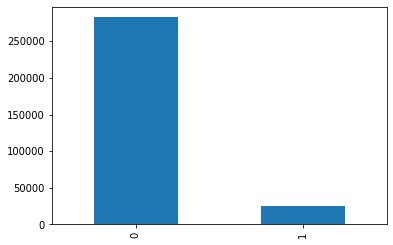

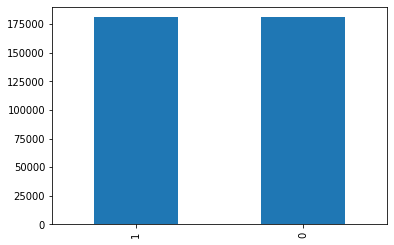

In [3]:
fig, ax = plt.subplots()
df['target'].value_counts().plot(ax=ax, kind='bar')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Oversampling target labels
max_size = train_df['target'].value_counts().max()

# lst = [train_df]
# for class_index, group in train_df.groupby('target'):
#     lst.append(group.sample(max_size-len(group), replace=True))
# X_train = pd.concat(lst)

X_train = train_df.drop(['target'], axis=1)
y_train = train_df['target']

rus = SMOTE(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_test = test_df.drop(['target'], axis=1)
y_test = test_df['target']

X_val = val_df.drop(['target'], axis=1)
y_val = val_df['target']

fig, ax = plt.subplots()
y_train.value_counts().plot(ax=ax, kind='bar')

# y_train = np.array(y_train, dtype=np.float32) 
# y_test = np.array(y_test, dtype=np.float32) 
# y_val = np.array(y_val, dtype=np.float32)

# y_train = y_train.flatten()
# y_test = y_test.flatten()
# y_val = y_val.flatten()



In [4]:
scaler = StandardScaler()
X_train_transform = scaler.fit_transform(X_train)
X_val_transform = scaler.transform(X_val)
X_test_transform = scaler.transform(X_test)

X_train_transform = pd.DataFrame(X_train_transform,columns = X_train.columns)
X_val_transform = pd.DataFrame(X_val_transform,columns = X_train.columns)
X_test_transform = pd.DataFrame(X_test_transform, columns = X_train.columns)

X_train_transform = np.clip(X_train_transform, -5, 5)
X_val_transform = np.clip(X_val_transform, -5, 5)
X_test_transform = np.clip(X_test_transform, -5, 5)

# BASELINE MODEL

In [42]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


params = {
    "layer1": 400,
    "layer2": 160,
    "layer3": 64,
    "layer4": 26,
    "layer5": 12,
    "epochs": 1000,
    "dropout": 0.3
}

def make_model(logits, last_nodes):
    model = Sequential()
    model.add(Dense(units = params['layer1'] , input_dim = X_train.shape[-1]))
    model.add(PReLU())
    model.add(Dropout(params['dropout']))
    model.add(Dense(units = params['layer2'] ))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout']))
    model.add(Dense(units = params['layer3']))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout']))
    model.add(Dense(units = params['layer4']))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout']))
    model.add(Dense(units = params['layer5'], activation="relu"))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout']))
    if not logits:
        model.add(Dense(last_nodes, activation='sigmoid'))
    else:
        model.add(Dense(last_nodes))    
    return model

In [17]:
# Binary classification
nn = make_model(logits=False, last_nodes=1)
nn.compile(loss=tf.keras.losses.BinaryCrossentropy, optimizer='adam', metrics=METRICS)
history = nn.fit(X_train_transform, y_train, epochs=30, batch_size=256, validation_data=(X_val_transform, y_val))

Epoch 1/30
1414/1414 [==============================] - 16s 10ms/step - loss: 0.6053 - accuracy: 0.6865 - precision: 0.6780 - recall: 0.7105 - auc: 0.7478 - prc: 0.7160 - val_loss: 0.5406 - val_accuracy: 0.7090 - val_precision: 0.1558 - val_recall: 0.5755 - val_auc: 0.7013 - val_prc: 0.1786
Epoch 2/30
1414/1414 [==============================] - 13s 9ms/step - loss: 0.5331 - accuracy: 0.7387 - precision: 0.7292 - recall: 0.7594 - auc: 0.8100 - prc: 0.7896 - val_loss: 0.4925 - val_accuracy: 0.7569 - val_precision: 0.1659 - val_recall: 0.4861 - val_auc: 0.6975 - val_prc: 0.1682
Epoch 3/30
1414/1414 [==============================] - 13s 9ms/step - loss: 0.5078 - accuracy: 0.7566 - precision: 0.7497 - recall: 0.7702 - auc: 0.8311 - prc: 0.8144 - val_loss: 0.4969 - val_accuracy: 0.7481 - val_precision: 0.1621 - val_recall: 0.4955 - val_auc: 0.6922 - val_prc: 0.1669
Epoch 4/30
1414/1414 [==============================] - 13s 9ms/step - loss: 0.4899 - accuracy: 0.7683 - precision: 0.7623 - r

In [18]:
scores = nn.evaluate(X_test_transform, y_test)
print("\n%s: %.2f%%" % (nn.metrics_names[1], scores[1]*100))

1922/1922 [==============================] - 7s 4ms/step - loss: 0.3795 - accuracy: 0.8309 - precision: 0.1879 - recall: 0.3318 - auc: 0.7030 - prc: 0.1651

accuracy: 83.09%


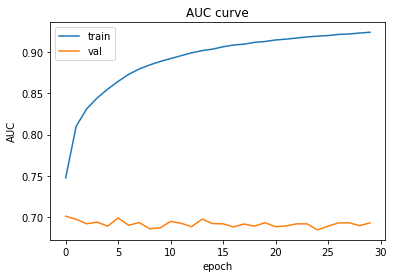

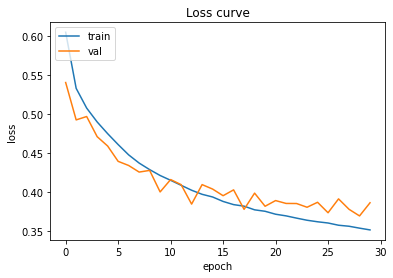

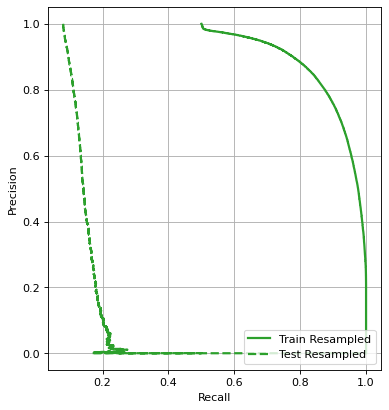

In [19]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC curve')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
train_predictions_resampled = nn.predict(X_train, batch_size=128)
test_predictions_resampled =  nn.predict(X_test, batch_size=128)
plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')



# results = model.evaluate(X_test, y_test, batch_size=64)

In [20]:
y_pred = nn.predict(X_test_transform)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["0","1"])

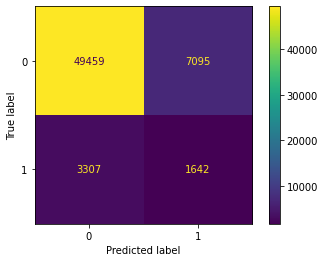

In [22]:
disp.plot()

# Membership Inference Attack

Membership Inference Attack (MIA) on machine learning models aim to identify whether a data sample was used to train the target machine learning model or not. 

MIA can raise severe privacy risks to individuals. For example, identifying that a certain patient’s clinical record was used to train a model associated with a disease reveals that the patient has this disease. 
MIA against ML models mainly focus on deep learning models because they are more prone to suffer from overfitting issues, which can be exploited by membership inference attacks
 
If our model behaves differently on both train and test datasets, it may be the case that the model overfits on the train data therefore is more vulnerable to MIA.

There are two types of MIA Attacks:
* Neural Network based attacks
* Metrics based attacks

 
Types of Membership Inference Attacks:
* Black-box inference attacks
* White-box inference attacks

Steps to mitigate MIA:

* Regularization to prevent overfitting.

* Using Differential Privacy as privacy enhancing technique

* Confidence score masking

Generalized steps to explore MIA:

* Load dataset & preprocess.
* Create the model without activation in the last layer and logits set to True in the loss function and train.
* Perform attack on the model and keep note of the relevant success metric (AUC used in this notebook).
* Implement differential privacy to see difference in the success metric (AUC used in this notebook).

In [25]:
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
from scipy import special

Imports for the Membership Inference Attack (MIA) , we proceed to import datastructures that will help with MIA.

`AttackInputData` is used to specify what information *f*<sub>*attack*</sub> will recieve. *f*<sub>*attack*</sub> is the binary classifier used to predict whether a data point was part of the training data or not. The *f*<sub>*attack*</sub>  is the binary classifier trained to predict, whether this data point was part of the training data or not. The input for the training the *f*<sub>*attack*</sub> are outputs (or other whitebox-like information) of a trained shadow models and the binary target is based on the dact that data has beeb used for training the associated shadow model.

We can provide these parameters for the `AttackInputData`:

* `train and test logits or train and test probabilities`
* `train and test loss`
* `train and test labels (as integer arrays)`

`SlicingSpec`: Provide us with the possibility of slicing our dataset. Using this datastructure, we can determine the success of the membership inference attack over specific data groups or classes. The following options can be set to True:

* `entire_dataset: one of the slices will be the entire dataset`
* `by_class: one slice per class is generated`
* `by_percentiles: generates 10 slices for percentiles of the loss - 0-10% 10-20%, … 90-100%`
* `by_classification_correctness: creates one slice for correctly classified data points, and one for misclassified data points. `

`AttackType`: Gives us different options on how our membership inference attack should be conducted. We can specify the model that we would like to use:

* `LOGISTIC_REGRESSION = ‘lr’`
* `MULTI_LAYERED_PERCEPTRON = ‘mlp’`
* `RANDOM_FOREST = ‘rf’`
* `K_NEAREST_NEIGHBORS = ‘knn’`
* `THRESHOLD_ATTACK = ‘threshold’`
* `THRESHOLD_ENTROPY_ATTACK = ‘threshold-entropy’`

The four first options require training a shadow model, the two last options don’t.

# Base Line Model with Logits Output

In [27]:
nn2 = make_model(logits=True, last_nodes=2)
nn2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
# nn2 = Sequential()
# nn2.add(Dense(units = params['layer1'] , input_dim = X_train.shape[-1]))
# nn2.add(PReLU())
# nn2.add(Dropout(params['dropout']))
# nn2.add(Dense(units = params['layer2'] ))
# nn2.add(PReLU())
# nn2.add(BatchNormalization())
# nn2.add(Dropout(params['dropout']))
# nn2.add(Dense(units = params['layer3']))
# nn2.add(PReLU())
# nn2.add(BatchNormalization())
# nn2.add(Dropout(params['dropout']))
# nn2.add(Dense(units = params['layer4']))
# nn2.add(PReLU())
# nn2.add(BatchNormalization())
# nn2.add(Dropout(params['dropout']))
# nn2.add(Dense(units = params['layer5'], activation="relu"))
# nn2.add(PReLU())
# nn2.add(BatchNormalization())
# nn2.add(Dropout(params['dropout']))
# nn2.add(Dense(2))
# nn2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [28]:
history = nn2.fit(X_train_transform, y_train, epochs=100, batch_size=256, validation_data=(X_val_transform, y_val))

Epoch 1/100
1414/1414 [==============================] - 12s 7ms/step - loss: 0.5921 - accuracy: 0.6932 - val_loss: 0.5005 - val_accuracy: 0.7457
Epoch 2/100
1414/1414 [==============================] - 10s 7ms/step - loss: 0.5302 - accuracy: 0.7411 - val_loss: 0.4915 - val_accuracy: 0.7596
Epoch 3/100
1414/1414 [==============================] - 10s 7ms/step - loss: 0.5071 - accuracy: 0.7561 - val_loss: 0.4879 - val_accuracy: 0.7632
Epoch 4/100
1414/1414 [==============================] - 10s 7ms/step - loss: 0.4904 - accuracy: 0.7684 - val_loss: 0.4491 - val_accuracy: 0.7974
Epoch 5/100
1414/1414 [==============================] - 10s 7ms/step - loss: 0.4764 - accuracy: 0.7761 - val_loss: 0.4725 - val_accuracy: 0.7726
Epoch 6/100
1414/1414 [==============================] - 10s 7ms/step - loss: 0.4632 - accuracy: 0.7837 - val_loss: 0.4581 - val_accuracy: 0.7852
Epoch 7/100
1414/1414 [==============================] - 10s 7ms/step - loss: 0.4525 - accuracy: 0.7905 - val_loss: 0.4761 -

### Before conducting the attack we need to calculate the inputs the attacker needs. Here we calculate the output logits, output probabilities and losses for train-test split

In [29]:
print('Predict on train...')
logits_train = nn2.predict(X_train_transform)

print('Predict on test...')
logits_test = nn2.predict(X_test_transform)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_1 = np.array(y_train, dtype=np.float32) 
y_test_1 = np.array(y_test, dtype=np.float32) 

y_train_1 = y_train_1.flatten()
y_test_1 = y_test_1.flatten()

y_train_onehot_1 = to_categorical(y_train_1)
y_test_onehot_1 = to_categorical(y_test_1)


loss_train = cce(constant(y_train_onehot_1), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot_1), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


### We define what variables our attacker has access too

In [30]:
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = y_train_1.astype(np.int8),
  labels_test = y_test_1.astype(np.int8)
)

### We specify data partitions that we would like to run attacks on

In [31]:
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

### Finally we define our attack types and run our attack

In [32]:
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [33]:
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.93 on slice CLASS=1
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an advantage of 0.70 on slice CLASS=1

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.72
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an AUC of 0.52
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an advantage of 0.03

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.93
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an advantage of 0.70

Best-performing attacks over 

Figure(432x288)


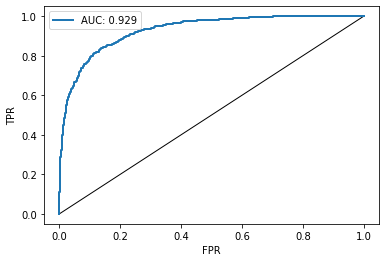

In [34]:
# We see that the attacker is much better than random accuracy
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

### Running Same Experiment with differential privacy

In [35]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer

### Baseline Model with Logits output and DP optimizer

In [36]:
noise_multiplier=.01
l2_norm_clip=1
num_microbatches=1

dp = DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,num_microbatches=num_microbatches)

nn3 = Sequential()
nn3.add(Dense(units = params['layer1'] , input_dim = X_train.shape[-1]))
nn3.add(PReLU())
nn3.add(Dropout(params['dropout']))
nn3.add(Dense(units = params['layer2'] ))
nn3.add(PReLU())
nn3.add(BatchNormalization())
nn3.add(Dropout(params['dropout']))
nn3.add(Dense(units = params['layer3']))
nn3.add(PReLU())
nn3.add(BatchNormalization())
nn3.add(Dropout(params['dropout']))
nn3.add(Dense(units = params['layer4']))
nn3.add(PReLU())
nn3.add(BatchNormalization())
nn3.add(Dropout(params['dropout']))
nn3.add(Dense(units = params['layer5'], activation="relu"))
nn3.add(PReLU())
nn3.add(BatchNormalization())
nn3.add(Dropout(params['dropout']))
nn3.add(Dense(2))
nn3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=dp, metrics=['accuracy'])

In [37]:
history = nn3.fit(X_train_transform, y_train, epochs=100, batch_size=256, validation_data=(X_val_transform, y_val))

Epoch 1/100
1414/1414 [==============================] - 26s 13ms/step - loss: 0.6294 - accuracy: 0.6636 - val_loss: 0.6180 - val_accuracy: 0.6370
Epoch 2/100
1414/1414 [==============================] - 18s 12ms/step - loss: 0.5763 - accuracy: 0.7048 - val_loss: 0.6220 - val_accuracy: 0.6383
Epoch 3/100
1414/1414 [==============================] - 18s 12ms/step - loss: 0.5650 - accuracy: 0.7155 - val_loss: 0.6124 - val_accuracy: 0.6462
Epoch 4/100
1414/1414 [==============================] - 18s 12ms/step - loss: 0.5574 - accuracy: 0.7205 - val_loss: 0.6212 - val_accuracy: 0.6468
Epoch 5/100
1414/1414 [==============================] - 18s 12ms/step - loss: 0.5538 - accuracy: 0.7236 - val_loss: 0.6209 - val_accuracy: 0.6529
Epoch 6/100
1414/1414 [==============================] - 18s 12ms/step - loss: 0.5503 - accuracy: 0.7265 - val_loss: 0.6248 - val_accuracy: 0.6521
Epoch 7/100
1414/1414 [==============================] - 18s 12ms/step - loss: 0.5482 - accuracy: 0.7275 - val_loss: 0

In [38]:
from copy import deepcopy
def membership_inference_attack(model, X_train, X_test, train_label, test_label):
    X_train = deepcopy(X_train)
    X_test = deepcopy(X_test)
    train_label = deepcopy(train_label)
    test_label = deepcopy(test_label)
    
    print('Predict on train...')
    logits_train = model.predict(X_train)

    print('Predict on test...')
    logits_test = model.predict(X_test)

    print('Apply softmax to get probabilities from logits...')
    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    print('Compute losses...')
    cce = tf.keras.backend.categorical_crossentropy
    constant = tf.keras.backend.constant

    y_train = np.array(train_label, dtype=np.float32) 
    y_test =  np.array(test_label, dtype=np.float32) 

    y_train = y_train.flatten()
    y_test = y_test.flatten()

    y_train_onehot = to_categorical(y_train)
    y_test_onehot = to_categorical(y_test)


    loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
    loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()   
    
    attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
    ]
    
    attack_input = AttackInputData(
      logits_train = logits_train,
      logits_test = logits_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = y_train.astype(np.int8),
      labels_test = y_test.astype(np.int8)
    )
    slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)
    
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)
    
    print(attacks_result.summary(by_slices=True))
    
    print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
loss train (361944,)
loss test (61503,)
y train (361944, 2)
y test (61503, 2)
Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 180972 training and 4949 test examples) achieved an AUC of 0.92 on slice CLASS=1
  THRESHOLD_ATTACK (with 180972 training and 4949 test examples) achieved an advantage of 0.68 on slice CLASS=1

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.72
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an AUC of 0.52
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an advantage of 0.03

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 180972 t

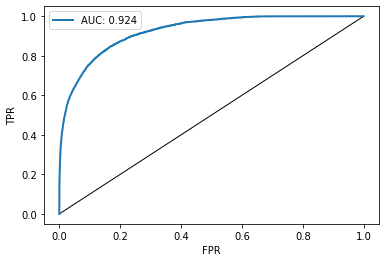

In [39]:
membership_inference_attack(nn2, X_train_transform, X_test_transform, y_train, y_test)

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
loss train (361944,)
loss test (61503,)
y train (361944, 2)
y test (61503, 2)
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 42438 training and 42438 test examples) achieved an AUC of 0.74 on slice CORRECTLY_CLASSIFIED=True
  LOGISTIC_REGRESSION (with 42438 training and 42438 test examples) achieved an advantage of 0.47 on slice CORRECTLY_CLASSIFIED=True

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.67
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.37

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.01

Best-performing attacks over slice:

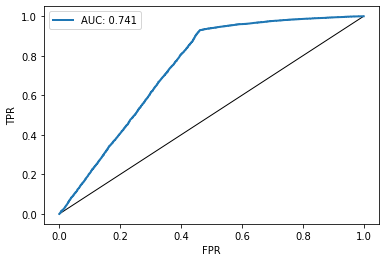

In [40]:
membership_inference_attack(nn3, X_train_transform, X_test_transform, y_train, y_test)

## Changing model architecture to  Binary from Multi Categorical Classification

In [43]:
mod1 = make_model(logits=True, last_nodes=1)
mod1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [44]:
history = mod1.fit(X_train_transform, y_train, epochs=50, batch_size=256, validation_data=(X_val_transform, y_val))

Epoch 1/50
1414/1414 [==============================] - 13s 8ms/step - loss: 0.5946 - accuracy: 0.6658 - val_loss: 0.5205 - val_accuracy: 0.8081
Epoch 2/50
1414/1414 [==============================] - 11s 8ms/step - loss: 0.5319 - accuracy: 0.7202 - val_loss: 0.4939 - val_accuracy: 0.8267
Epoch 3/50
1414/1414 [==============================] - 10s 7ms/step - loss: 0.5080 - accuracy: 0.7412 - val_loss: 0.5033 - val_accuracy: 0.8098
Epoch 4/50
1414/1414 [==============================] - 11s 8ms/step - loss: 0.4903 - accuracy: 0.7538 - val_loss: 0.4963 - val_accuracy: 0.8172
Epoch 5/50
1414/1414 [==============================] - 11s 8ms/step - loss: 0.4772 - accuracy: 0.7625 - val_loss: 0.4760 - val_accuracy: 0.8292
Epoch 6/50
1414/1414 [==============================] - 11s 8ms/step - loss: 0.4633 - accuracy: 0.7702 - val_loss: 0.4830 - val_accuracy: 0.8272
Epoch 7/50
1414/1414 [==============================] - 11s 8ms/step - loss: 0.4527 - accuracy: 0.7779 - val_loss: 0.4571 - val_ac

## DP-Binary

In [45]:
noise_multiplier=.01
l2_norm_clip=1
num_microbatches=1

dp = DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,num_microbatches=num_microbatches)

mod2 = make_model(logits=True, last_nodes=1)
mod2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=dp, metrics=['accuracy'])
history = mod2.fit(X_train_transform, y_train, epochs=50, batch_size=256, validation_data=(X_val_transform, y_val))

Epoch 1/50
1414/1414 [==============================] - 27s 14ms/step - loss: 0.6361 - accuracy: 0.6305 - val_loss: 0.6145 - val_accuracy: 0.7531
Epoch 2/50
1414/1414 [==============================] - 19s 13ms/step - loss: 0.5770 - accuracy: 0.6783 - val_loss: 0.6245 - val_accuracy: 0.7411
Epoch 3/50
1414/1414 [==============================] - 19s 13ms/step - loss: 0.5656 - accuracy: 0.6915 - val_loss: 0.6203 - val_accuracy: 0.7426
Epoch 4/50
1414/1414 [==============================] - 19s 13ms/step - loss: 0.5586 - accuracy: 0.6987 - val_loss: 0.6171 - val_accuracy: 0.7440
Epoch 5/50
1414/1414 [==============================] - 19s 13ms/step - loss: 0.5545 - accuracy: 0.7047 - val_loss: 0.6225 - val_accuracy: 0.7397
Epoch 6/50
1414/1414 [==============================] - 19s 13ms/step - loss: 0.5507 - accuracy: 0.7075 - val_loss: 0.6141 - val_accuracy: 0.7451
Epoch 7/50
1414/1414 [==============================] - 19s 13ms/step - loss: 0.5475 - accuracy: 0.7104 - val_loss: 0.6222 -

In [47]:
from copy import deepcopy
def membership_inference_attack_binary(model, X_train, X_test, train_label, test_label):
    X_train = deepcopy(X_train)
    X_test = deepcopy(X_test)
    train_label = deepcopy(train_label)
    test_label = deepcopy(test_label)
    
    print('Predict on train...')
    logits_train = model.predict(X_train)

    print('Predict on test...')
    logits_test = model.predict(X_test)

    print('Apply softmax to get probabilities from logits...')
    prob_train = special.expit(logits_train)
    prob_test = special.expit(logits_test)
    y_train_pred = np.argmax(prob_train)
    y_test_pred = np.argmax(prob_test)
    
    print('Compute losses...')
    bce = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant

    y_train = np.array(train_label, dtype=np.float32) 
    y_test =  np.array(test_label, dtype=np.float32) 

    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    loss_train = bce(constant(y_train), constant(y_train_pred), from_logits=False).numpy()
    loss_test = bce(constant(y_test), constant(y_test_pred), from_logits=False).numpy()
    
    attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
    ]
    
    attack_input = AttackInputData(
      logits_train = logits_train,
      logits_test = logits_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = y_train.astype(np.int8),
      labels_test = y_test.astype(np.int8)
    )
    slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)
    
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)
    
    print(attacks_result.summary(by_slices=True))
    
    print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.91 on slice CLASS=1
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an advantage of 0.66 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.72
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.45

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an AUC of 0.52
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.03

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0

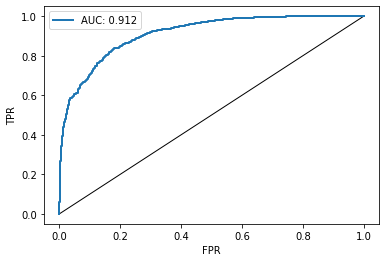

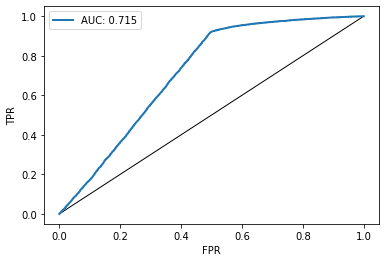

In [48]:
membership_inference_attack_binary(mod1, X_train_transform, X_test_transform, y_train, y_test)
membership_inference_attack_binary(mod2, X_train_transform, X_test_transform, y_train, y_test)